# Demo the Arbitrageur Agent Logic

This notebook:

1. Fetches the latest crvusd contract data into Python objects using `crvusdsim`.
2. Fetches prices and `ExternalMarket`s from the `baseline` scenario.
3. Instantiates an Arbitrageur agent.
4. Checks if there are profitable arbitrages and performs them.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from crvusdsim.pool import get
from src.agents.arbitrageur import Arbitrageur
from src.sim.scenario import Scenario
from src.utils.poolgraph import PoolGraph
from src.configs import SYMBOL_TO_ADDRESS
from src.configs.tokens import *
from src.modules import ExternalMarket


%load_ext autoreload
%autoreload 2

In [2]:
arbitrageur = Arbitrageur()

ETH_POOL = "weth"
sim_market = get(ETH_POOL, bands_data="controller")
pool = sim_market.pool
stableswap_pools = sim_market.stableswap_pools

In [3]:
# Generate markets and prices
config = "../src/configs/scenarios/baseline.json"
scenario = Scenario(config)
markets = scenario.generate_markets()
prices = scenario.generate_pricepaths("../" + scenario.price_config)
scenario.update_market_prices(prices[-1])

[INFO][19:33:25][root]-577354: Reading price config from ../src/configs/scenarios/baseline.json.
[INFO][19:33:25][root]-577354: Fetching 1inch quotes.


[INFO][19:33:31][root]-577354: We have 465120 quotes.
[INFO][19:33:31][root]-577354: Fitting external markets against 1inch quotes.
[INFO][19:33:31][root]-577354: Reading price config from ../src/configs/prices/1h_1696108632_1701289032.json.


In [4]:
# Create a list of all stableswap pools, LLAMMAs, and External Markets.
markets_lst = list(markets.values())
pools = stableswap_pools + [pool] + markets_lst
print(
    f"There are {len(pools)} total pools:\nStableSwap: {len(stableswap_pools)}\nLLAMMA: 1\nExternal Markets: {len(markets_lst)}"
)

There are 20 total pools:
StableSwap: 4
LLAMMA: 1
External Markets: 15


In [5]:
n = 3
graph = PoolGraph(pools)
cycles = graph.find_cycles(n=n)
cycles

[INFO][19:33:31][root]-577354: Found 20 valid cycles of length 3.


[Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=None), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDP, in=Curve.Fi USD Stablecoin (crvUSD), out=USDP, amt=None), Swap(pool=External Market (TUSD, USDP), in=Pax Dollar, out=TrueUSD, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=None), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=Curve.Fi USD Stablecoin (crvUSD), out=USDC, amt=None), Swap(pool=External Market (TUSD, USDC), in=USD Coin, out=TrueUSD, amt=None)], Expected Profit: None),
 Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/TUSD, in=TUSD, out=Curve.Fi USD Stablecoin (crvUSD), amt=None), Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=Curve.Fi USD Stablecoin (crvUSD), out=USDT, amt=None), Swap(pool=External Market (TUSD, USDT), in=Tether USD, out=TrueUSD, amt=None)], Expect

In [6]:
df = pd.DataFrame(
    columns=["amt_optimize", "amt_linspace", "profit_optimize", "profit_linspace"]
)

for i, cycle in enumerate(cycles):
    try:
        # This is orders of magnitude slower than `optimize`
        trade = cycle.trades[0]
        high = trade.pool.get_max_trade_size(trade.i, trade.j)
        amts = np.linspace(0, high, 1000)
        amts = [int(amt) for amt in amts]
        profits = [cycle.populate(amt) for amt in amts]

        best_amt_linspace = int(amts[np.argmax(profits)])
        best_profit_linspace = int(max(profits))

        cycle.optimize()

        df.loc[i] = [
            cycle.trades[0].amt,
            best_amt_linspace,
            cycle.expected_profit,
            best_profit_linspace,
        ]

    except Exception as e:
        logging.error(f"Cycle {i} failed to optimize: {e}")

df["profit_linspace"] = df["profit_linspace"].astype(float)
df["profit_optimize"] = df["profit_optimize"].astype(float)
df = df.round(3)
df

,amt_optimize,amt_linspace,profit_optimize,profit_linspace
0,86.0,0.0,-0.000,0.0
1,152341805817814.0,0.0,-0.000,0.0
2,139347137905748.0,0.0,-0.000,0.0
3,937348941625737657450496,890422835248267723276288,21647.871,21817.0
4,427974998238280202321920,427484031179380215513088,1527.759,1526.0
5,144674067649218696183808,143662666216021212266496,50.251,50.0
6,7352012436093962027008,7007934937366888710144,0.156,0.0
7,792312764160234068377600,791896647922458445217792,22102.732,22099.0
8,814728361214.0,804296660986.0,2088.179,2087.0
9,285.0,0.0,-0.000,0.0


Best amount linspace: 427484031179380215513088
Best profit linspace: 1526.6622683156768
Best amount optimize: 427974998238280202321920
Best profit optimize: 1527.7590489057523


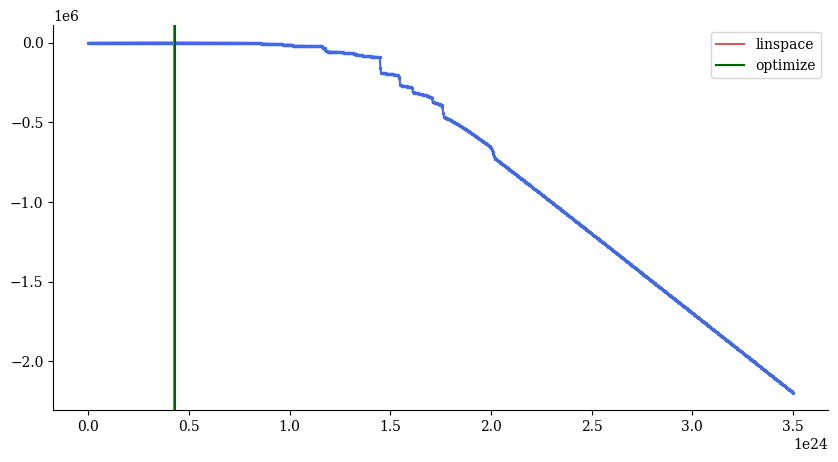

In [7]:
# TODO this curve is probably not smooth because:
# 1. The decimals are not being treated correctly between trades <- fixed
# 2. The state of each pool is not being snapshot correctly (i.e. it's changing) <- ??
# 3. I think it's because External Market slippage is noisy. <- fixed

i = 4
cycle = cycles[i]

trade = cycle.trades[0]
high = trade.pool.get_max_trade_size(trade.i, trade.j)
amts = np.linspace(1, high, 1000)
amts = [int(amt) for amt in amts]
profits = [cycle.populate(amt) for amt in amts]

best_amt_linspace = amts[np.argmax(profits)]
best_profit_linspace = max(profits)

# compare
cycle.optimize()
best_amt_optimize = cycle.trades[0].amt
best_profit_optimize = cycle.expected_profit

f, ax = plt.subplots(figsize=(10, 5))
ax.scatter(amts, profits, color="royalblue", s=2)
ax.plot(amts, profits, color="royalblue")
ax.axvline(best_amt_linspace, color="indianred", label="linspace")
ax.axvline(best_amt_optimize, color="darkgreen", label="optimize")

# NOTE Uncomment to zoom into optimal region
# diff = abs(best_amt_optimize - best_amt_linspace)
# xlims = (float(min(best_amt_optimize, best_amt_linspace) - diff), float(max(best_amt_optimize, best_amt_linspace) + diff))
# tmp = [p for p, a in zip(profits, amts) if xlims[0] < a < xlims[1]]
# ylims = min(tmp), max(tmp)
# ax.set_xlim(*xlims)
# ax.set_ylim(*ylims)

ax.legend()

print(f"Best amount linspace: {best_amt_linspace}")
print(f"Best profit linspace: {best_profit_linspace}")
print(f"Best amount optimize: {best_amt_optimize}")
print(f"Best profit optimize: {best_profit_optimize}")

# Analyzing arbitrages

In [8]:
def test():
    best = arbitrageur.find_best_arbitrage(cycles)

    # get the trades in the cycle
    # the price of pool 1 * price of pool 2 should approach pool 3
    def get_prices(cycle):
        prices = []
        for trade in best.trades:
            price = trade.pool.price(trade.i, trade.j)
            if not isinstance(trade.pool, ExternalMarket):
                price /= 1e18
            prices.append(price)
        return prices

    prices = get_prices(best)

    print(f"Pre Trade prices: {prices}")
    print(f"External Market price: {prices[2]}")
    print(f"Curve pool prices: {prices[0] * prices[1]}")
    print()

    best.execute()
    prices = get_prices(best)

    print(f"Post Trade prices: {prices}")
    print(f"External Market price: {prices[2]}")
    print(f"Curve pool prices: {prices[0] * prices[1]}")


# test()

In [9]:
prices[-1]._prices[USDC]

1.0011044583713429

In [12]:
profit, count = arbitrageur.arbitrage(cycles, prices[-1])
profit, count

[INFO][19:34:37][root]-577354: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=USDT, out=Curve.Fi USD Stablecoin (crvUSD), amt=1250539706102), Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=1253546408252564597921018), Swap(pool=External Market (WETH, USDT), in=Wrapped Ether, out=Tether USD, amt=617201276136138462181)], Expected Profit: 31436.678638).
[INFO][19:34:37][root]-577354: Executing trade Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDT, in=USDT, out=Curve.Fi USD Stablecoin (crvUSD), amt=1250539706102).
[INFO][19:34:37][root]-577354: Executing trade Swap(pool=Curve.fi Stablecoin WETH, in=crvUSD, out=WETH, amt=1253546408252564597921018).
[INFO][19:34:37][root]-577354: Executing trade Swap(pool=External Market (WETH, USDT), in=Wrapped Ether, out=Tether USD, amt=617201276136138462181).
[INFO][19:34:37][root]-577354: Executing cycle Cycle(Trades: [Swap(pool=Curve.fi Factory Plain Pool: crvUSD/USDC, in=USDC, out=Curve.Fi USD Stab